In [44]:
# --- Make "src" importable from notebooks ----
import sys
import pathlib

# Current working dir when running notebook
cwd = pathlib.Path().resolve()

# If we are inside the notebooks/ folder, go one level up (project root)
if cwd.name == "notebooks":
    PROJECT_ROOT = cwd.parent
else:
    PROJECT_ROOT = cwd  # in case Jupyter starts at project root

# Add project root to Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)

PROJECT_ROOT: C:\Users\srida\OneDrive\Desktop\repos\DisasterTweets-Classifier


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#from datasets import Dataset
from transformers import (AutoTokenizer,AutoModelForSequenceClassification,TrainingArguments,Trainer)

from src.config import TWEETS_CSV

sns.set_theme(style="whitegrid")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,precision_recall_fscore_support,classification_report,confusion_matrix,f1_score)
import nltk
from nltk.corpus import stopwords

from src.config import TWEETS_CSV
from src.data.preprocess import preprocess_series


OSError: [WinError 127] The specified procedure could not be found. Error loading "c:\Users\srida\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\lib\c10_cuda.dll" or one of its dependencies.

In [14]:
import nltk
nltk.download("stopwords")

STOPWORDS = set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\srida\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
df = pd.read_csv(TWEETS_CSV)
df.head()


,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7952 non-null   object
 3   text      11370 non-null  object
 4   target    11370 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 444.3+ KB


In [18]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,11370.0,NaN,NaN,NaN,5684.5,3282.380615,0.0,2842.25,5684.5,8526.75,11369.0
keyword,11370,219,thunderstorm,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,7952,4504,United States,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text,11370,11223,I want to help you with my project to save the...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
target,11370.0,NaN,NaN,NaN,0.185928,0.389066,0.0,0.0,0.0,0.0,1.0


In [19]:
df.isna().sum()

id             0
keyword        0
location    3418
text           0
target         0
dtype: int64

In [20]:
df["keyword"] = df["keyword"].fillna("unknown")
df["location"] = df["location"].fillna("unknown")
df.isna().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [21]:
df["text_len"] = df["text"].str.len()
df["word_count"] = df["text"].str.split().apply(len)

df[["text_len", "word_count"]].describe()

,text_len,word_count
count,11370.000000,11370.000000
mean,107.571944,17.166139
std,30.135399,5.510808
min,5.000000,1.000000
25%,94.000000,14.000000
50%,119.000000,18.000000
75%,126.000000,21.000000
max,149.000000,32.000000


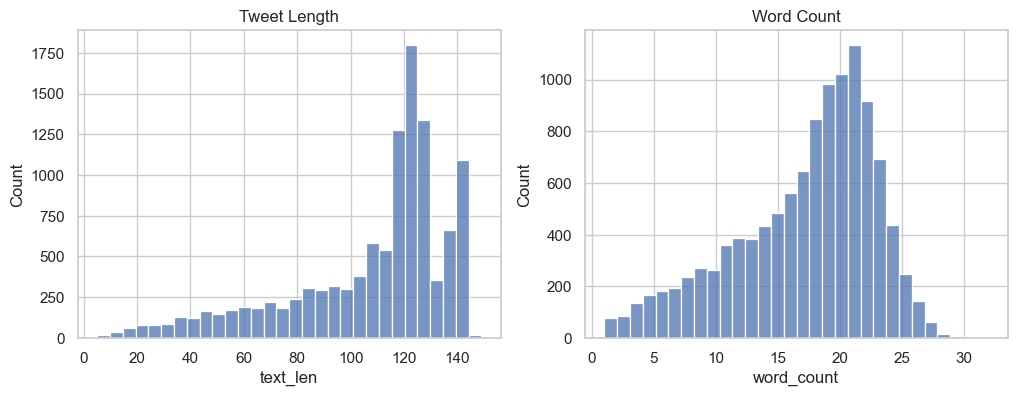

In [22]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df["text_len"], bins=30)
plt.title("Tweet Length")

plt.subplot(1,2,2)
sns.histplot(df["word_count"], bins=30)
plt.title("Word Count")

plt.show()


In [23]:
Q1 = df["text_len"].quantile(0.25)
Q3 = df["text_len"].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
upper_bound

174.0

In [24]:
(df["text_len"] > upper_bound).sum()

0

In [25]:
df["text_len_capped"] = df["text_len"].clip(upper=upper_bound)

In [26]:
df["num_hashtags"] = df["text"].str.count("#")
df["num_mentions"] = df["text"].str.count("@")
df["num_urls"] = df["text"].str.count("http")

df.head()

,id,keyword,location,text,target,text_len,word_count,text_len_capped,num_hashtags,num_mentions,num_urls
0,0,ablaze,unknown,"Communal violence in Bhainsa, Telangana. ""Ston...",1,125,19,125,0,0,0
1,1,ablaze,unknown,Telangana: Section 144 has been imposed in Bha...,1,131,23,131,0,0,0
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1,63,7,63,0,0,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1,87,8,87,0,0,2
4,4,ablaze,unknown,"""Lord Jesus, your love brings freedom and pard...",0,140,23,140,0,0,1


In [27]:
df["clean_text"] = preprocess_series(df["text"])
df[["text", "clean_text"]].head()

,text,clean_text
0,"Communal violence in Bhainsa, Telangana. ""Ston...",communal violence bhainsa telangana stones pel...
1,Telangana: Section 144 has been imposed in Bha...,telangana section imposed bhainsa january clas...
2,Arsonist sets cars ablaze at dealership https:...,arsonist sets cars ablaze dealership
3,Arsonist sets cars ablaze at dealership https:...,arsonist sets cars ablaze dealership
4,"""Lord Jesus, your love brings freedom and pard...",lord jesus love brings freedom pardon fill hol...


In [28]:
from sklearn.model_selection import train_test_split

FEATURES = ["clean_text", "text_len_capped", "word_count", "num_hashtags", "num_mentions", "num_urls"]
TARGET = "target"

X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((9096, 6), (2274, 6))

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

text_col = "clean_text"
num_cols = ["text_len_capped", "word_count", "num_hashtags", "num_mentions", "num_urls"]

preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=20000, ngram_range=(1,2)), text_col),
        ("num", StandardScaler(), num_cols)
    ]
)

clf = LogisticRegression(max_iter=1000, class_weight="balanced")

model = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", clf)
])


In [30]:
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('text', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [31]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.8478452066842568

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      1851
           1       0.57      0.75      0.65       423

    accuracy                           0.85      2274
   macro avg       0.75      0.81      0.77      2274
weighted avg       0.87      0.85      0.86      2274



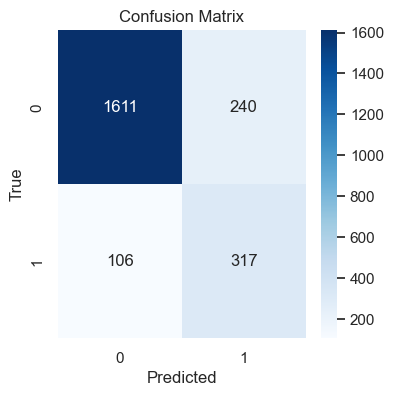

In [32]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [33]:
df = pd.read_csv(TWEETS_CSV)

# Handle missing values
df["keyword"] = df["keyword"].fillna("unknown")
df["location"] = df["location"].fillna("unknown")

# Basic numeric features
df["text_len"] = df["text"].str.len()
df["word_count"] = df["text"].str.split().apply(len)
df["num_hashtags"] = df["text"].str.count("#")
df["num_mentions"] = df["text"].str.count("@")
df["num_urls"] = df["text"].str.count("http")

# Cap extreme text lengths (IQR)
Q1 = df["text_len"].quantile(0.25)
Q3 = df["text_len"].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
df["text_len_capped"] = df["text_len"].clip(upper=upper_bound)

# Clean text
df["clean_text"] = preprocess_series(df["text"])

df.head()


,id,keyword,location,text,target,text_len,word_count,num_hashtags,num_mentions,num_urls,text_len_capped,clean_text
0,0,ablaze,unknown,"Communal violence in Bhainsa, Telangana. ""Ston...",1,125,19,0,0,0,125,communal violence bhainsa telangana stones pel...
1,1,ablaze,unknown,Telangana: Section 144 has been imposed in Bha...,1,131,23,0,0,0,131,telangana section imposed bhainsa january clas...
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1,63,7,0,0,1,63,arsonist sets cars ablaze dealership
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1,87,8,0,0,2,87,arsonist sets cars ablaze dealership
4,4,ablaze,unknown,"""Lord Jesus, your love brings freedom and pard...",0,140,23,0,0,1,140,lord jesus love brings freedom pardon fill hol...


In [34]:
FEATURE_TEXT_COL = "clean_text"
NUM_COLS = ["text_len_capped", "word_count", "num_hashtags", "num_mentions", "num_urls"]
TARGET_COL = "target"

X = df[[FEATURE_TEXT_COL] + NUM_COLS]
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

X_train.shape, X_test.shape


((9096, 6), (2274, 6))

In [35]:
from sklearn.preprocessing import StandardScaler

text_vectorizer = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
)

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_vectorizer, FEATURE_TEXT_COL),
        ("num", numeric_transformer, NUM_COLS),
    ]
)


In [36]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", pos_label=1, zero_division=0
    )

    print(f"\n===== {name} =====")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("\nClassification report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return {"model": name, "acc": acc, "precision": precision, "recall": recall, "f1": f1}


In [37]:
models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000, class_weight="balanced", n_jobs=-1
    ),
    "LinearSVM": LinearSVC(class_weight="balanced"),
    "MultinomialNB": MultinomialNB(),  # text part only (works with non-negative features)
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        n_jobs=-1,
        class_weight="balanced",
        random_state=42,
    ),
}



===== LogisticRegression =====
Accuracy : 0.8478
Precision: 0.5691
Recall   : 0.7494
F1-score : 0.6469

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90      1851
           1       0.57      0.75      0.65       423

    accuracy                           0.85      2274
   macro avg       0.75      0.81      0.77      2274
weighted avg       0.87      0.85      0.86      2274



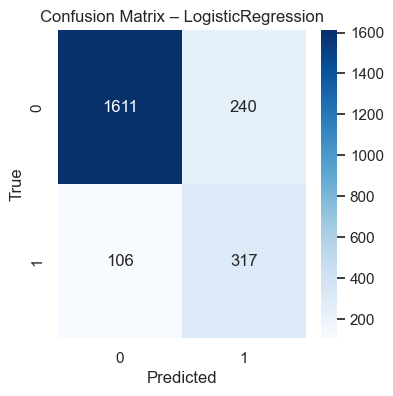


===== LinearSVM =====
Accuracy : 0.8624
Precision: 0.6185
Recall   : 0.6785
F1-score : 0.6471

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      1851
           1       0.62      0.68      0.65       423

    accuracy                           0.86      2274
   macro avg       0.77      0.79      0.78      2274
weighted avg       0.87      0.86      0.86      2274



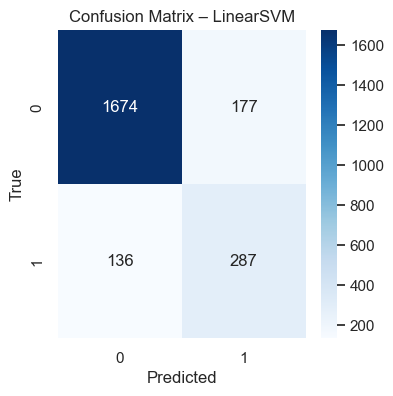


===== MultinomialNB =====
Accuracy : 0.8606
Precision: 0.9492
Recall   : 0.2648
F1-score : 0.4140

Classification report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92      1851
           1       0.95      0.26      0.41       423

    accuracy                           0.86      2274
   macro avg       0.90      0.63      0.67      2274
weighted avg       0.87      0.86      0.83      2274



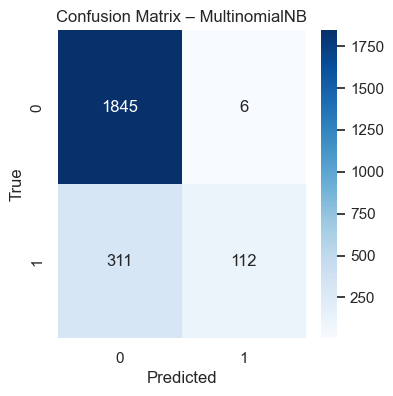


===== RandomForest =====
Accuracy : 0.8791
Precision: 0.8394
Recall   : 0.4326
F1-score : 0.5710

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93      1851
           1       0.84      0.43      0.57       423

    accuracy                           0.88      2274
   macro avg       0.86      0.71      0.75      2274
weighted avg       0.88      0.88      0.86      2274



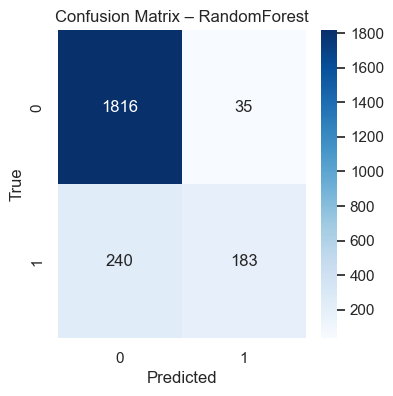

,model,acc,precision,recall,f1
0,LogisticRegression,0.847845,0.569120,0.749409,0.646939
1,LinearSVM,0.862357,0.618534,0.678487,0.647125
2,MultinomialNB,0.860598,0.949153,0.264775,0.414048
3,RandomForest,0.879068,0.839450,0.432624,0.570983


In [38]:
results = []

for name, clf in models.items():
    # For MultinomialNB, it's better to ignore numeric (because of negative values after scaling).
    if name == "MultinomialNB":
        preproc_nb = ColumnTransformer(
            transformers=[
                ("text", text_vectorizer, FEATURE_TEXT_COL)
            ]
        )
        pipe = Pipeline([
            ("preprocess", preproc_nb),
            ("clf", clf),
        ])
    else:
        pipe = Pipeline([
            ("preprocess", preprocessor),
            ("clf", clf),
        ])

    res = evaluate_model(name, pipe, X_train, y_train, X_test, y_test)
    results.append(res)

results_df = pd.DataFrame(results)
results_df


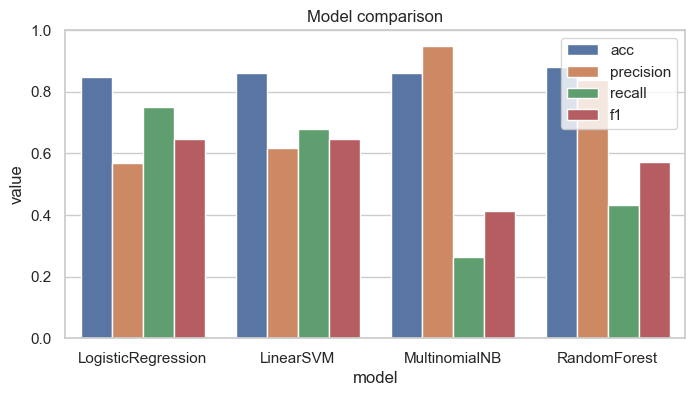

In [39]:
plt.figure(figsize=(8,4))
sns.barplot(data=results_df.melt(id_vars="model", value_vars=["acc", "precision", "recall", "f1"]),
            x="model", y="value", hue="variable")
plt.ylim(0,1)
plt.title("Model comparison")
plt.legend(title="")
plt.show()
